## Step 1: Dependencies

Install all the Huggingface python packages

In [5]:
%%capture
!pip install git+https://github.com/huggingface/diffusers.git
!pip install accelerate
!pip install datasets
!pip install bitsandbytes

Define a simple function to plot a list of images returned from the model when generating

In [7]:
def plot_images(images):
    from matplotlib import pyplot as plt
    plt.figure()
    f, axarr = plt.subplots(1, len(images), figsize=(20,10))
    for ax, img in zip(axarr.flatten(), images):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

Import the relevant python libraries to load and sample from the Stable Diffusion model

In [8]:
import os
import torch

from diffusers import StableDiffusionPipeline
from diffusers import DiffusionPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [9]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Step 2: Fine-tune the model

Let's clone the dataset from and the hugging face

In [10]:
!git clone https://huggingface.co/datasets/nadavo11/King-Louis

Cloning into 'King-Louis'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 78 (delta 9), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (78/78), 17.18 KiB | 676.00 KiB/s, done.
Filtering content: 100% (53/53), 90.00 MiB | 36.41 MiB/s, done.


and then clone the dataset and the hugging face code which contains the finetuning script

In [11]:
!git clone https://github.com/huggingface/diffusers.git

fatal: destination path 'diffusers' already exists and is not an empty directory.


Set some flags for the finetuning script, the dataset to be used and the number of iterations. Since the dataset we chose is small and we want to finetune quickly using the colab free tier, let's only finetune for 50 epochs

# sample from the dataset


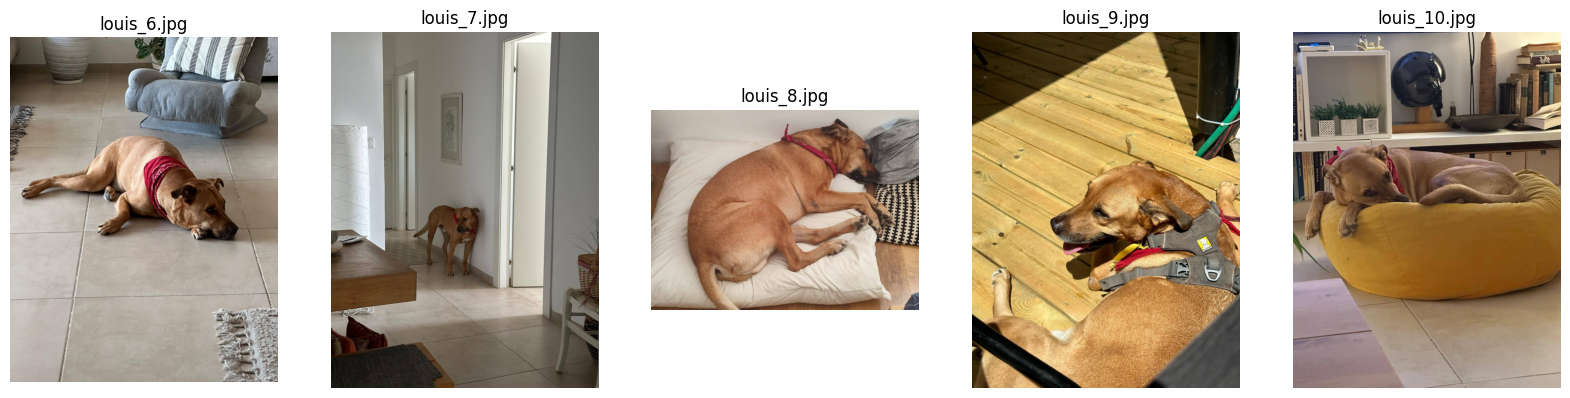

In [13]:
path_to_dataset = '/content/King-Louis'
imgs = os.listdir(path_to_dataset)
from PIL import Image
import matplotlib.pyplot as plt
import os

# Assuming that the "data/" folder contains images (replace with the correct local folder path)
image_folder = "/content/King-Louis/data/"

# Display a few sample images from the folder
image_files = [f"louis_{i+5}.jpg" for i in range(1, 6)]  # Showing first 5 images
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i, img_file in enumerate(image_files):
    img_path = os.path.join(image_folder, img_file)

    try:
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(img_file)
        axes[i].axis('off')
    except Exception as e:
        axes[i].text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
        axes[i].set_title(img_file)
        axes[i].axis('off')

plt.show()

Now we run the actual fine-tuning script. **IMPORTANT:** Remember if you want to train on google's free T4 GPU it's crucial to add the flag

```
--use_8bit_adam
```
We will save the model in the *city-building-model* folder


In [14]:
DATASET_NAME = 'King-Louis' #@param {'type':'string'}
MODEL_NAME = 'stabilityai/stable-diffusion-2-1' #@param {'type':'string'}
MAX_TRAINING_EPOCHS = 200 #@param {'type':'integer'}
MODEL_TARGET_FOLDER = 'King-Louis-model' #@param {'type':'string'}

In [ ]:
# del pipe
# del images

In [15]:
# The --use_8bit_adam flag is crucial to be able to train on the T4 GPU which has only 15GB of memory
!accelerate launch diffusers/examples/text_to_image/train_text_to_image.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --dataset_name=$DATASET_NAME \
  --use_ema \
  --use_8bit_adam \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --gradient_checkpointing \
  --mixed_precision="fp16" \
  --max_train_steps=$MAX_TRAINING_EPOCHS \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --lr_scheduler="constant" --lr_warmup_steps=0 \
  --output_dir=$MODEL_TARGET_FOLDER

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2024-09-07 15:09:28.506763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 15:09:28.540446: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 15:09:28.551659: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alread

## Step 3: Sample from the finetuned model

We load the new model in the GPU (this time we don't need to Download anything as the fine-tuned model has been saved locally) and generate some more images

In [16]:
pipe = StableDiffusionPipeline.from_pretrained(MODEL_TARGET_FOLDER, torch_dtype=torch.float16)
pipe = pipe.to("cuda")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [27]:

prompt = "Louis the Dog with his red bandana" # @param {"type":"string"}
negative_prompt = "deformed face, ugly face, two heads " # @param {"type":"string"}
inference_steps = 40 # @param {"type":"integer"}
num_images = 5 # @param {"type":"integer"}
guidance_scale = 8 # @param {"type":"number"}
images = pipe(prompt,
              negative_prompt=negative_prompt,
              num_inference_steps = inference_steps,
              guidance_scale = guidance_scale,
              num_images_per_prompt=num_images,

              ).images

  0%|          | 0/40 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

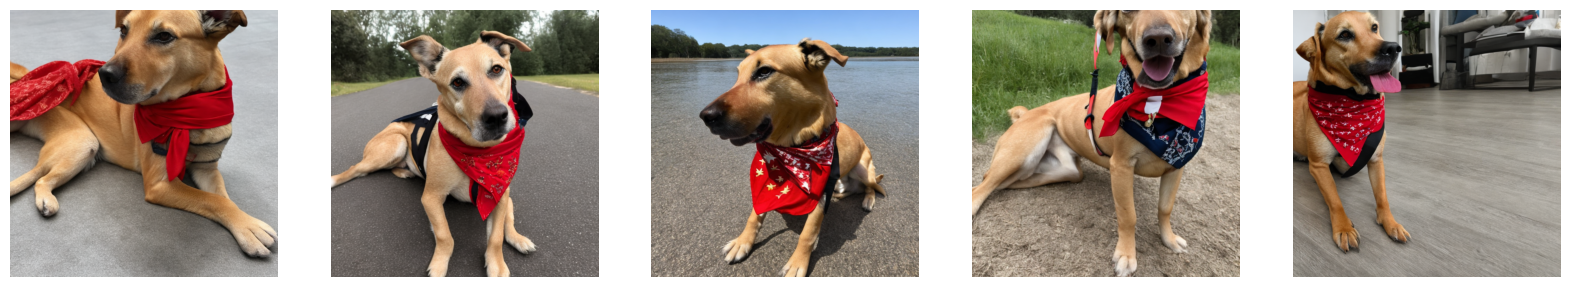

In [28]:
plot_images(images)